In [2]:
import pandas as pd

# 데이터 로드
data = pd.read_csv("statiz_game_schedule_10_years_with_labels.csv")

# 열 이름 확인 및 수정
data.rename(columns={"Team1": "Away_Team", "Team2": "Home_Team"}, inplace=True)  # 반대로 설정

# 승리 여부 계산
def calculate_winner(row):
    if row['Score1'] > row['Score2']:
        return row['Home_Team']
    elif row['Score1'] < row['Score2']:
        return row['Away_Team']
    else:
        return "Draw"

data['Winner'] = data.apply(calculate_winner, axis=1)

# 경기 결과 기록 (홈팀 기준)
data['Home_Win'] = (data['Winner'] == data['Home_Team']).astype(int)
data['Away_Win'] = (data['Winner'] == data['Away_Team']).astype(int)

# 팀별 승률 계산
team_stats = data.groupby('Home_Team').agg(
    Total_Home_Games=('Home_Team', 'count'),
    Total_Home_Wins=('Home_Win', 'sum')
).reset_index()

team_stats['Home_Win_Rate'] = team_stats['Total_Home_Wins'] / team_stats['Total_Home_Games']

# 데이터에 홈팀 승률 병합
data = data.merge(team_stats[['Home_Team', 'Home_Win_Rate']], on='Home_Team', how='left')

# 직전 경기 결과 계산
data['Match_Key'] = data.apply(lambda x: tuple(sorted([x['Home_Team'], x['Away_Team']])), axis=1)
data = data.sort_values('Date')

previous_results = {}
last_result = []

for index, row in data.iterrows():
    match_key = row['Match_Key']
    if match_key in previous_results:
        last_result.append(previous_results[match_key])
    else:
        last_result.append(None)
    previous_results[match_key] = row['Score2'] - row['Score1']  # 현재 경기 결과 저장 (수정)

data['Previous_Result'] = last_result

# 결과 확인
data[['Date', 'Home_Team', 'Away_Team', 'Home_Win_Rate', 'Previous_Result']].head()


,Date,Home_Team,Away_Team,Home_Win_Rate,Previous_Result
0,2015-03-28,두산,NC,0.416442,NaN
1,2015-03-28,넥센,한화,0.432432,NaN
2,2015-03-28,삼성,SK,0.482711,NaN
3,2015-03-28,KIA,LG,0.464336,NaN
4,2015-03-28,롯데,KT,0.481793,NaN


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 데이터 로드 및 열 이름 수정
data = pd.read_csv("statiz_game_schedule_10_years_with_labels.csv")

# 데이터 순서에 따라 열 이름 수정
data.rename(columns={"Team1": "Away_Team", "Score1": "Away_Score",
                     "Team2": "Home_Team", "Score2": "Home_Score"}, inplace=True)

# 승리 여부 계산
def calculate_winner(row):
    if row['Home_Score'] > row['Away_Score']:
        return row['Home_Team']
    elif row['Home_Score'] < row['Away_Score']:
        return row['Away_Team']
    else:
        return "Draw"

data['Winner'] = data.apply(calculate_winner, axis=1)
data['Home_Win'] = (data['Winner'] == data['Home_Team']).astype(int)

# 팀별 승률 계산
team_stats = data.groupby('Home_Team').agg(
    Total_Home_Games=('Home_Team', 'count'),
    Total_Home_Wins=('Home_Win', 'sum')
).reset_index()

team_stats['Home_Win_Rate'] = team_stats['Total_Home_Wins'] / team_stats['Total_Home_Games']
data = data.merge(team_stats[['Home_Team', 'Home_Win_Rate']], on='Home_Team', how='left')

# 직전 경기 결과 계산
data['Match_Key'] = data.apply(lambda x: tuple(sorted([x['Home_Team'], x['Away_Team']])), axis=1)
data = data.sort_values('Date')

previous_results = {}
last_result = []

for index, row in data.iterrows():
    match_key = row['Match_Key']
    if match_key in previous_results:
        last_result.append(previous_results[match_key])
    else:
        last_result.append(None)
    previous_results[match_key] = row['Home_Score'] - row['Away_Score']  # 홈팀 - 원정팀 점수 차이

data['Previous_Result'] = last_result

# 입력 데이터 준비
data['Month'] = pd.to_datetime(data['Date']).dt.month
X = data[['Home_Team', 'Away_Team', 'Month', 'Home_Win_Rate', 'Previous_Result']].fillna(0)
y = data['Odd_Even'].apply(lambda x: 1 if x == 'E' else 0)

# 범주형 변수 인코딩
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = encoder.fit_transform(X[['Home_Team', 'Away_Team', 'Month']])
categorical_features_df = pd.DataFrame(categorical_features, columns=encoder.get_feature_names_out(['Home_Team', 'Away_Team', 'Month']))

# 수치형 변수와 결합
numerical_features = X[['Home_Win_Rate', 'Previous_Result']].reset_index(drop=True)
X_encoded = pd.concat([categorical_features_df, numerical_features], axis=1)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 개별 모델 정의
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
gb_clf = GradientBoostingClassifier(random_state=42, n_estimators=100)
lr_clf = LogisticRegression(random_state=42, max_iter=200)
svc_clf = SVC(probability=True, random_state=42)

# 앙상블 모델 정의 (VotingClassifier)
ensemble_model = VotingClassifier(
    estimators=[
        ('Random Forest', rf_clf),
        ('Gradient Boosting', gb_clf),
        ('Logistic Regression', lr_clf),
        ('SVC', svc_clf)
    ],
    voting='soft'
)

# 모델 학습
ensemble_model.fit(X_train, y_train)

# 예측
y_pred = ensemble_model.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Feature Importance 계산 (Random Forest와 Gradient Boosting)
def compute_feature_importances(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        return pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
    else:
        return None

# 범주형 및 수치형 변수 이름 결합
feature_names = list(encoder.get_feature_names_out(['Home_Team', 'Away_Team', 'Month'])) + ['Home_Win_Rate', 'Previous_Result']

# Random Forest Feature Importances
rf_importances = compute_feature_importances(rf_clf, feature_names)

# Gradient Boosting Feature Importances
gb_importances = compute_feature_importances(gb_clf, feature_names)

# 출력
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

if rf_importances is not None:
    print("\nRandom Forest Feature Importances:\n", rf_importances.head(10))

if gb_importances is not None:
    print("\nGradient Boosting Feature Importances:\n", gb_importances.head(10))


Accuracy: 0.5500

Confusion Matrix:
 [[663 217]
 [436 135]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67       880
           1       0.38      0.24      0.29       571

    accuracy                           0.55      1451
   macro avg       0.49      0.49      0.48      1451
weighted avg       0.52      0.55      0.52      1451



Epoch 1/500


c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5388 - loss: 0.6928 - val_accuracy: 0.6065 - val_loss: 0.6734
Epoch 2/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5626 - loss: 0.6852 - val_accuracy: 0.6065 - val_loss: 0.6783
Epoch 3/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.5563 - loss: 0.6858 - val_accuracy: 0.6065 - val_loss: 0.6780
Epoch 4/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.5650 - loss: 0.6823 - val_accuracy: 0.6058 - val_loss: 0.6773
Epoch 5/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5493 - loss: 0.6875 - val_accuracy: 0.6065 - val_loss: 0.6770
Epoch 6/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.5580 - loss: 0.6846 - val_accuracy: 0.6065 - val_loss: 0.6791
Epoch 7/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5618 - loss: 0.6804 - val_accuracy: 0.6065 - val_loss: 0.6777
Epoch 8/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5701 - loss: 0.6773 - val_accu

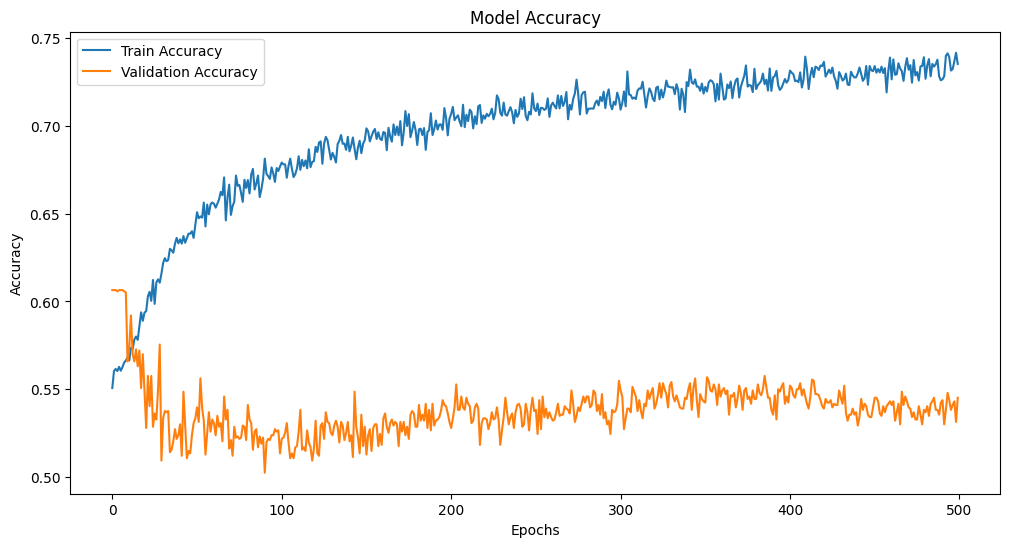

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 데이터 로드 및 전처리
data = pd.read_csv("statiz_game_schedule_10_years_with_labels.csv")

# 열 이름 수정
data.rename(columns={"Team1": "Away_Team", "Score1": "Away_Score",
                     "Team2": "Home_Team", "Score2": "Home_Score"}, inplace=True)

# 승리 여부 계산
def calculate_winner(row):
    if row['Home_Score'] > row['Away_Score']:
        return row['Home_Team']
    elif row['Home_Score'] < row['Away_Score']:
        return row['Away_Team']
    else:
        return "Draw"

data['Winner'] = data.apply(calculate_winner, axis=1)
data['Home_Win'] = (data['Winner'] == data['Home_Team']).astype(int)

# 팀별 승률 계산
team_stats = data.groupby('Home_Team').agg(
    Total_Home_Games=('Home_Team', 'count'),
    Total_Home_Wins=('Home_Win', 'sum')
).reset_index()

team_stats['Home_Win_Rate'] = team_stats['Total_Home_Wins'] / team_stats['Total_Home_Games']
data = data.merge(team_stats[['Home_Team', 'Home_Win_Rate']], on='Home_Team', how='left')

# 직전 경기 결과 계산
data['Match_Key'] = data.apply(lambda x: tuple(sorted([x['Home_Team'], x['Away_Team']])), axis=1)
data = data.sort_values('Date')

previous_results = {}
last_result = []

for index, row in data.iterrows():
    match_key = row['Match_Key']
    if match_key in previous_results:
        last_result.append(previous_results[match_key])
    else:
        last_result.append(None)
    previous_results[match_key] = row['Home_Score'] - row['Away_Score']

data['Previous_Result'] = last_result

# 입력 데이터 준비
data['Month'] = pd.to_datetime(data['Date']).dt.month
X = data[['Home_Team', 'Away_Team', 'Month', 'Home_Win_Rate', 'Previous_Result']].fillna(0)
y = data['Odd_Even'].apply(lambda x: 1 if x == 'E' else 0)

# 범주형 변수 인코딩
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = encoder.fit_transform(X[['Home_Team', 'Away_Team', 'Month']])

# 수치형 변수 스케일링
scaler = StandardScaler()
numerical_features = scaler.fit_transform(X[['Home_Win_Rate', 'Previous_Result']])

# 최종 입력 데이터 결합
X_encoded = pd.concat(
    [pd.DataFrame(categorical_features), pd.DataFrame(numerical_features)], axis=1
)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 딥러닝 모델 설계
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # 출력층
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=500, batch_size=32, verbose=1)

# 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 학습 곡선 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/500


c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4819 - loss: 1.6042 - val_accuracy: 0.4604 - val_loss: 1.4881
Epoch 2/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.4894 - loss: 1.4792 - val_accuracy: 0.5341 - val_loss: 1.3785
Epoch 3/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.5109 - loss: 1.3681 - val_accuracy: 0.5817 - val_loss: 1.2882
Epoch 4/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.5083 - loss: 1.2860 - val_accuracy: 0.5961 - val_loss: 1.2101
Epoch 5/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.5260 - loss: 1.2092 - val_accuracy: 0.6037 - val_loss: 1.1417
Epoch 6/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5350 - loss: 1.1370 - val_accuracy: 0.6065 - val_loss: 1.0813
Epoch 7/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.5369 - loss: 1.0805 - val_accuracy: 0.6065 - val_loss: 1.0280
Epoch 8/500
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5488 - loss: 1.0313 - val_ac

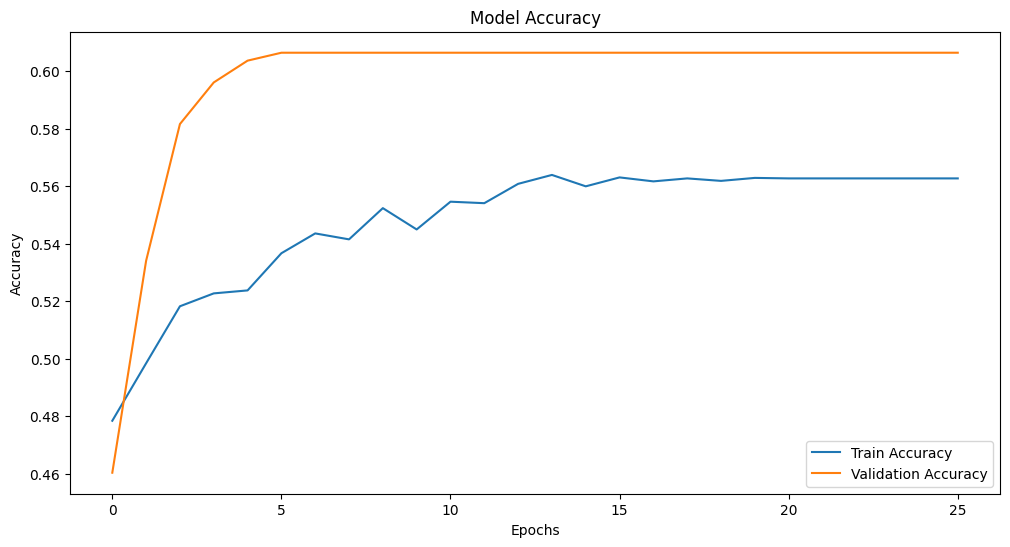

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 데이터 로드 및 전처리
data = pd.read_csv("statiz_game_schedule_10_years_with_labels.csv")

# 열 이름 수정
data.rename(columns={"Team1": "Away_Team", "Score1": "Away_Score",
                     "Team2": "Home_Team", "Score2": "Home_Score"}, inplace=True)

# 승리 여부 계산
def calculate_winner(row):
    if row['Home_Score'] > row['Away_Score']:
        return row['Home_Team']
    elif row['Home_Score'] < row['Away_Score']:
        return row['Away_Team']
    else:
        return "Draw"

data['Winner'] = data.apply(calculate_winner, axis=1)
data['Home_Win'] = (data['Winner'] == data['Home_Team']).astype(int)

# 팀별 승률 계산
team_stats = data.groupby('Home_Team').agg(
    Total_Home_Games=('Home_Team', 'count'),
    Total_Home_Wins=('Home_Win', 'sum')
).reset_index()

team_stats['Home_Win_Rate'] = team_stats['Total_Home_Wins'] / team_stats['Total_Home_Games']
data = data.merge(team_stats[['Home_Team', 'Home_Win_Rate']], on='Home_Team', how='left')

# 직전 경기 결과 계산
data['Match_Key'] = data.apply(lambda x: tuple(sorted([x['Home_Team'], x['Away_Team']])), axis=1)
data = data.sort_values('Date')

previous_results = {}
last_result = []

for index, row in data.iterrows():
    match_key = row['Match_Key']
    if match_key in previous_results:
        last_result.append(previous_results[match_key])
    else:
        last_result.append(None)
    previous_results[match_key] = row['Home_Score'] - row['Away_Score']

data['Previous_Result'] = last_result

# 입력 데이터 준비
data['Month'] = pd.to_datetime(data['Date']).dt.month
X = data[['Home_Team', 'Away_Team', 'Month', 'Home_Win_Rate', 'Previous_Result']].fillna(0)
y = data['Odd_Even'].apply(lambda x: 1 if x == 'E' else 0)

# 범주형 변수 인코딩
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = encoder.fit_transform(X[['Home_Team', 'Away_Team', 'Month']])

# 수치형 변수 스케일링
scaler = StandardScaler()
numerical_features = scaler.fit_transform(X[['Home_Win_Rate', 'Previous_Result']])

# 최종 입력 데이터 결합
X_encoded = pd.concat(
    [pd.DataFrame(categorical_features), pd.DataFrame(numerical_features)], axis=1
)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 딥러닝 모델 설계
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Dropout 비율 증가
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 출력층
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=500, batch_size=32, verbose=1, callbacks=[early_stopping])

# 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 학습 곡선 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


다시 데이터추가

In [8]:
# 필요한 데이터 구성: 어웨이팀, 어웨이점수, 홈팀, 홈점수, 승점합, 홀짝여부, 승리팀,
# 팀간의 직전 5경기 승률, 팀간의 점수차이 평균, 팀별 월별 경기 성과, 특정 팀의 홈 및 원정 여부

# 1. 기본 데이터 준비
data['Total_Score'] = data['Home_Score'] + data['Away_Score']
data['Odd_Even'] = data['Total_Score'].apply(lambda x: 'E' if x % 2 == 0 else 'O')

# 2. 팀간 직전 5경기 승률 및 점수차이 평균 계산
def calculate_head_to_head_stats(home_team, away_team, date, num_games=5):
    head_to_head_games = data[((data['Home_Team'] == home_team) & (data['Away_Team'] == away_team)) |
                              ((data['Home_Team'] == away_team) & (data['Away_Team'] == home_team))]
    past_games = head_to_head_games[head_to_head_games['Date'] < date].sort_values(by='Date', ascending=False).head(num_games)

    if past_games.empty:
        return 0, 0

    win_count = 0
    score_diff_sum = 0

    for _, game in past_games.iterrows():
        if (game['Home_Team'] == home_team and game['Home_Score'] > game['Away_Score']) or \
           (game['Away_Team'] == home_team and game['Away_Score'] > game['Home_Score']):
            win_count += 1
        score_diff_sum += abs(game['Home_Score'] - game['Away_Score'])

    win_rate = win_count / len(past_games)
    avg_score_diff = score_diff_sum / len(past_games)
    return win_rate, avg_score_diff

data['HeadToHead_5Game_WinRate'] = 0.0
data['HeadToHead_ScoreDiff'] = 0.0

for index, row in data.iterrows():
    win_rate, score_diff = calculate_head_to_head_stats(row['Home_Team'], row['Away_Team'], row['Date'])
    data.at[index, 'HeadToHead_5Game_WinRate'] = win_rate
    data.at[index, 'HeadToHead_ScoreDiff'] = score_diff

# 3. 팀별 월별 경기 성과 계산
team_monthly_performance = team_data.groupby(['Team', 'Month'])['Win'].mean().reset_index()
team_monthly_performance.rename(columns={'Win': 'Monthly_Performance'}, inplace=True)

data = data.merge(team_monthly_performance, left_on=['Home_Team', 'Month'], right_on=['Team', 'Month'], how='left')
data.rename(columns={'Monthly_Performance': 'Home_Monthly_Performance'}, inplace=True)
data = data.merge(team_monthly_performance, left_on=['Away_Team', 'Month'], right_on=['Team', 'Month'], how='left')
data.rename(columns={'Monthly_Performance': 'Away_Monthly_Performance'}, inplace=True)

# 4. 특정 팀의 홈 및 원정 여부
data['Is_Home_Game'] = 1
data['Is_Away_Game'] = 1

# 필요한 열 선택
final_data = data[['Away_Team', 'Away_Score', 'Home_Team', 'Home_Score', 'Total_Score', 'Odd_Even',
                   'Winner', 'HeadToHead_5Game_WinRate', 'HeadToHead_ScoreDiff',
                   'Home_Monthly_Performance', 'Away_Monthly_Performance', 'Is_Home_Game', 'Is_Away_Game']]

# 저장
output_path = "statiz_game_final_features.xlsx"
final_data.to_excel(output_path, index=False)
output_path


NameError: name 'team_data' is not defined